<a href="https://colab.research.google.com/github/elreweidy/Pneumonia_classification/blob/main/Pneumonia_classification_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import os 
import cv2 
import time 
import copy

import pandas as pd
import torch 
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt 
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
! mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/kaggle_api_credentials/kaggle.json ~/.kaggle/kaggle.json

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:46<00:00, 24.5MB/s]
100% 2.29G/2.29G [01:46<00:00, 23.2MB/s]


In [8]:
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [9]:
# labels = ['PNEUMONIA', 'NORMAL']
# img_size = 150
# def get_training_data(data_dir):
#     data = [] 
#     for label in labels: 
#         path = os.path.join(data_dir, label)
#         class_num = labels.index(label)
#         for img in os.listdir(path):
#             try:
#                 img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
#                 resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
#                 data.append([resized_arr, class_num])
#             except Exception as e:
#                 print(e)
#     return np.array(data)

In [11]:
train = 'chest_xray/train'
val = 'chest_xray/val'
test = 'chest_xray/test'

In [12]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l) 

IndexError: ignored

In [13]:
transformers = {
    'dataset1': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ColorJitter(brightness=0.5),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomGrayscale(),
        transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
        transforms.ToTensor(),

    ]),
    
    'dataset2' : transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ColorJitter(brightness=0.5),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomGrayscale(),
        transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
        transforms.ToTensor(),
                                    
    ]),

     'dataset3' : transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ColorJitter(brightness=0.5),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomGrayscale(),
        transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
        transforms.ToTensor(),

     ]),
                }

In [14]:
train_path = 'chest_xray/train'
dataset1 = ImageFolder(train_path, 
                      transform=transformers['dataset1'])

dataset2 = ImageFolder(train_path, 
                      transform=transformers['dataset2'])

dataset3 = ImageFolder(train_path, 
                      transform=transformers['dataset3'])

norm1, _ = train_test_split(dataset2, test_size= 3875/(1341+3875), shuffle=False)
norm2, _ = train_test_split(dataset3, test_size= 4023/(1341+3875), shuffle=False)



In [15]:
dataset = ConcatDataset([dataset1, norm1, norm2])

len(dataset)

7750

In [16]:
random_seed = 42
torch.manual_seed(random_seed);

In [17]:
train_ds, val_ds = train_test_split(dataset, test_size=0.3, random_state=random_seed)
len(train_ds), len(val_ds)

(5425, 2325)

In [18]:
batch_size=64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
loaders = {'train':train_dl, 'val':val_dl}
dataset_sizes = {'train':len(train_ds), 'val':len(val_ds)}

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


we can visualize the whole batch with this function.

In [18]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:batch_size], nrow=10).permute(1, 2, 0))
        break

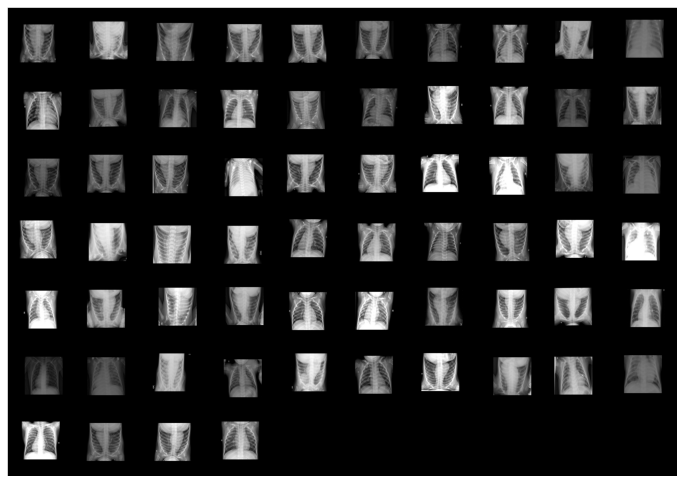

In [19]:
show_batch(train_dl)

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

In [20]:
model = torchvision.models.densenet161(pretrained=True)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

In [21]:
for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier.in_features

model.classifier = nn.Linear(in_features, 2)

In [22]:
#save the losses for further visualization
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

In [23]:
def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)

In [25]:
model.to(device)
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/10
train - loss:0.2991897897456648, accuracy0.8930875576036866
val - loss:0.17904640842509525, accuracy0.9432258064516129
Time: 1.0m 0.8683960437774658s
Epoch: 2/10
train - loss:0.17952974120318066, accuracy0.9380645161290323
val - loss:0.1461910073218807, accuracy0.9518279569892473
Time: 1.0m 54.337159395217896s
Epoch: 3/10
train - loss:0.16132020340537145, accuracy0.9419354838709677
val - loss:0.13420392750411905, accuracy0.9556989247311828
Time: 2.0m 48.969016790390015s
Epoch: 4/10
train - loss:0.14456476068853782, accuracy0.9482027649769585
val - loss:0.12367281275410806, accuracy0.9595698924731183
Time: 3.0m 42.896801710128784s
Epoch: 5/10
train - loss:0.13479354298746532, accuracy0.9539170506912442
val - loss:0.12302647579100824, accuracy0.9574193548387097
Time: 4.0m 37.13702321052551s
Epoch: 6/10
train - loss:0.1305236866891659, accuracy0.9564976958525345
val - loss:0.1222749561391851, accuracy0.9608602150537634
Time: 5.0m 31.052896738052368s
Epoch: 7/10
train - loss:0.

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs*2+1))
ax1.plot(epoch_list, accuracies['train'], label='Train Accuracy')
ax1.plot(epoch_list, accuracies['val'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs*2+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, losses['train'], label='Train Loss')
ax2.plot(epoch_list, losses['val'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs*2+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

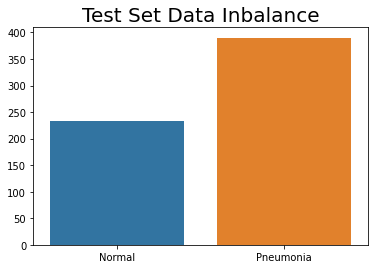

In [30]:
path='chest_xray'
test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/test/NORMAL', filename) 
                     for filename in os.listdir(path+'/test/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/test/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/test/PNEUMONIA')])]})

sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

In [31]:
def validation_step(batch):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        out = model(images)                                      
        loss = F.cross_entropy(out, labels)                    
        acc,preds = accuracy(out, labels)                       
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}

In [32]:
def test_prediction(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()             
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}  

In [33]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [validation_step(batch) for batch in test_loader] 
    results = test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [36]:
testset = ImageFolder(path+'/test', 
                           transform=transforms.Compose([transforms.Resize(255),
                                                 transforms.CenterCrop(224),                                                              
                                                 transforms.ToTensor(),
                                                ]))

In [ ]:
test_dl = DataLoader(testset, batch_size=256)
model.to(device)
preds,labels = test_predict(model, test_dl)